# Training Strategy 3: Chronological Split

Motivation: Prevent leaking of future data into training data. 
Approach: Always predict into the future.  Test set is always in the future. 

In [22]:
import pandas as pd
weather_df = pd.read_csv('/Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/data/weather_data_cleaned.csv')
crowd_df = pd.read_csv('/Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/data/sensor_data.csv')
crowd_df['timestamp'] = pd.to_datetime(crowd_df['timestamp'], utc=False)
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'], utc=False)
weather_df = weather_df.rename(columns={'datetime': 'timestamp'})
weather_df['timestamp'] = weather_df['timestamp'].dt.tz_localize(None)
crowd_df['timestamp'] = crowd_df['timestamp'].dt.tz_localize(None)

merged_df = pd.merge_asof(
    crowd_df,
    weather_df,
    on = 'timestamp',
    direction = 'nearest',
    tolerance = pd.Timedelta('60min')
)
sensor_cols = merged_df.columns[1:-14]
feature_cols = merged_df.columns[-14:]
# Ensure the timestamp column is datetime
merged_df['timestamp'] = pd.to_datetime(merged_df['timestamp'])

# Set it as index
merged_df.set_index('timestamp', inplace=True)

# Check index dtype
print(merged_df.index.dtype)  # should be datetime64[ns]

# Display first few rows
merged_df.head()

datetime64[ns]


CMSA-GAKH-01_0  CMSA-GAKH-01_180  CMSA-GAWW-11_120  \
timestamp                                                                 
2025-08-20 00:00:00              15                 4                29   
2025-08-20 00:03:00               1                 3                21   
2025-08-20 00:06:00               5                 4                35   
2025-08-20 00:09:00               4                 4                40   
2025-08-20 00:12:00               4                11                54   

                     CMSA-GAWW-11_300  CMSA-GAWW-12_115  CMSA-GAWW-12_295  \
timestamp                                                                   
2025-08-20 00:00:00                33                44                28   
2025-08-20 00:03:00                29                34                39   
2025-08-20 00:06:00                22                29                34   
2025-08-20 00:09:00                47                42                40   
2025-08-20 00:12:00                59                58                33   

                     CMSA-GAWW-13_120  CMSA-GAWW-13_300  CMSA-GAWW-14_40  \
timestamp                                                                  
2025-08-20 00:00:00                42                37               11   
2025-08-20 00:03:00                 9                14                6   
2025-08-20 00:06:00                33                42               14   
2025-08-20 00:09:00                19                34               15   
2025-08-20 00:12:00                17                33               26   

                     CMSA-GAWW-14_220  ...  weekday  is_weekend  temperature  \
timestamp                              ...                                     
2025-08-20 00:00:00                 3  ...        2           0         16.8   
2025-08-20 00:03:00                 6  ...        2           0         16.8   
2025-08-20 00:06:00                 3  ...        2           0         16.8   
2025-08-20 00:09:00                 2  ...        2           0         16.8   
2025-08-20 00:12:00                 9  ...        2           0         16.8   

                     dew_point  air_pressure  wind_speed  max_gust  rainfall  \
timestamp                                                                      
2025-08-20 00:00:00       12.5        1014.6         4.0       7.0       0.0   
2025-08-20 00:03:00       12.5        1014.6         4.0       7.0       0.0   
2025-08-20 00:06:00       12.5        1014.6         4.0       7.0       0.0   
2025-08-20 00:09:00       12.5        1014.6         4.0       7.0       0.0   
2025-08-20 00:12:00       12.5        1014.6         4.0       7.0       0.0   

                     sunshine_duration  relative_humidity  
timestamp                                                  
2025-08-20 00:00:00                0.0                 75  
2025-08-20 00:03:00                0.0                 75  
2025-08-20 00:06:00                0.0                 75  
2025-08-20 00:09:00                0.0                 75  
2025-08-20 00:12:00                0.0                 75  

[5 rows x 88 columns]

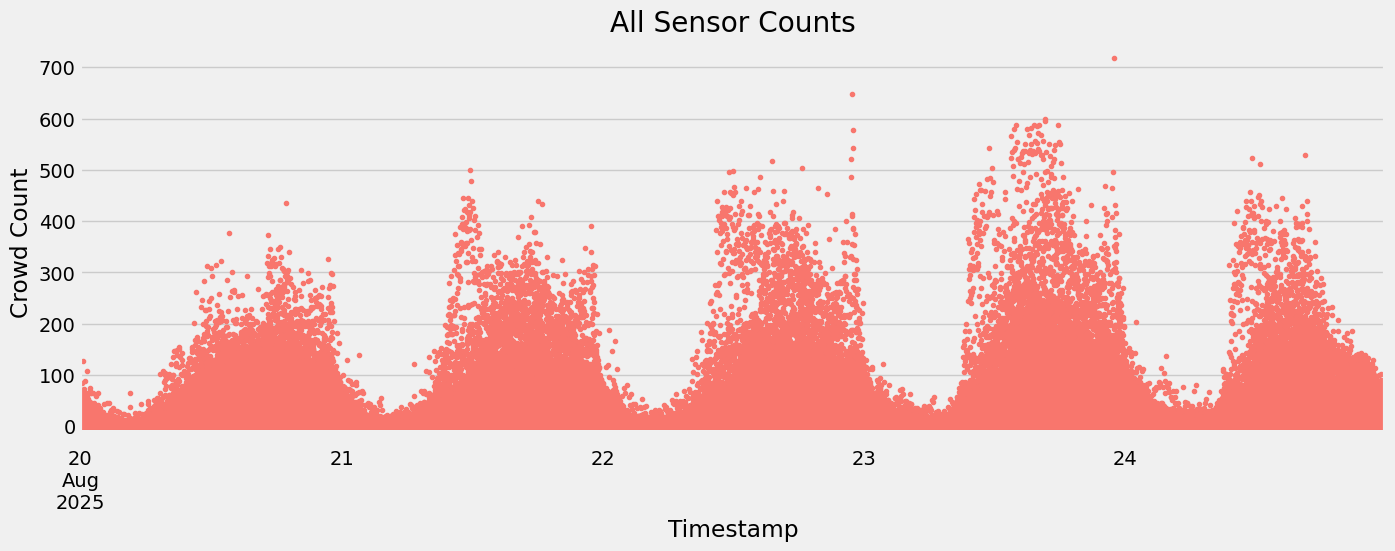

In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

# Plot all sensors
ax = merged_df[sensor_cols].plot(
    figsize=(15,5),
    style='.', 
    color=color_pal[0],
    title='All Sensor Counts',
    legend = False
)

ax.set_xlabel('Timestamp')
ax.set_ylabel('Crowd Count')
plt.show()



In [24]:
# start_date = '22-Aug-2025'
# end_date = '24-Aug-2025'
split_date = '23-Aug-2025'
merged_df_train = merged_df.loc[merged_df.index <= split_date].copy()
merged_df_test = merged_df.loc[merged_df.index > split_date].copy()


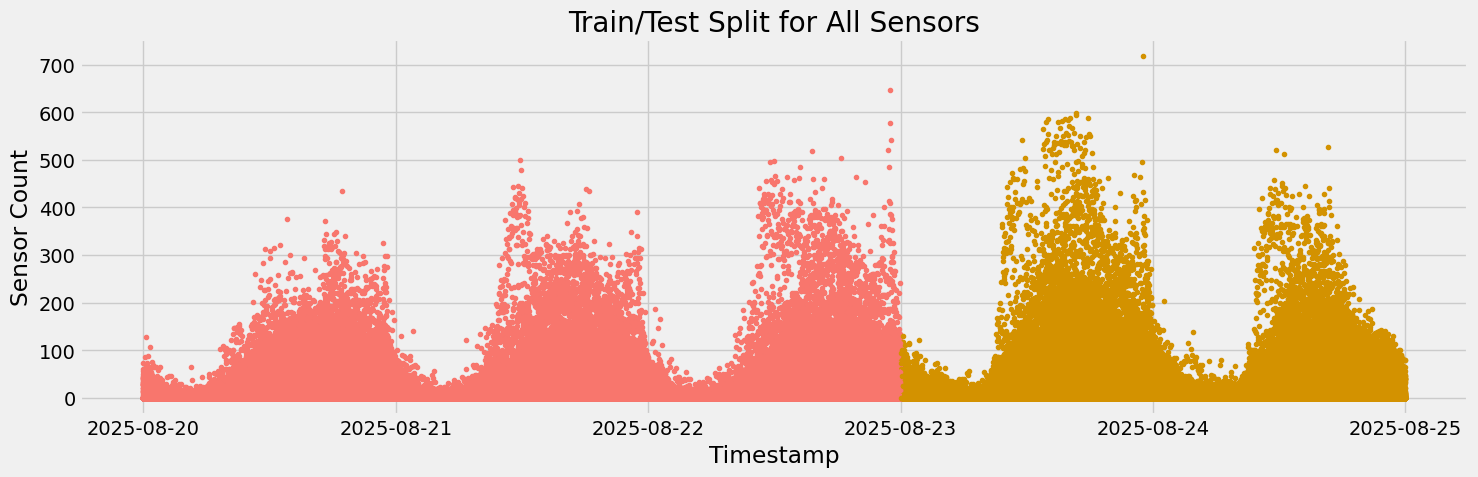

In [25]:
plt.figure(figsize=(15,5))

for sensor in sensor_cols:
    plt.plot(merged_df_train.index, merged_df_train[sensor], '.', label=f'{sensor} - TRAIN', color =color_pal[0])
    plt.plot(merged_df_test.index, merged_df_test[sensor], '.', label=f'{sensor} - TEST', color = color_pal[1])

plt.title('Train/Test Split for All Sensors')
plt.xlabel('Timestamp')
plt.ylabel('Sensor Count')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

In [26]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
import xgboost as xgb
import os 

xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 6,
    'objective': 'reg:squarederror',
    'random_state': 43,
    'verbosity': 0,
    'n_jobs': -1
}

OUT_DIR = '/Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/TS_3_models_xgb' # Output directory to store models 
os.makedirs(OUT_DIR, exist_ok=True)

X_train = merged_df_train[feature_cols]
X_test = merged_df_test[feature_cols]

# Scale features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(OUT_DIR, 'scaler.joblib')) # save scaler used


models = {} # dictionary to store models
mae_per_sensor = [] # mean absolute error
r2_per_sensor = [] # r2 score


for i, sensor in enumerate(sensor_cols):
    print(f"\nTraining sensor {i+1}/{len(sensor_cols)}: {sensor}")
    
    y_train = merged_df.loc[X_train.index, sensor]
    y_test = merged_df.loc[X_test.index, sensor]

    # Train model
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(
        X_train_scaled, y_train,
        eval_set=[(X_test_scaled, y_test)],
        verbose=False
    )

    # Predict on test
    y_pred = model.predict(X_test_scaled)

    # Save model
    model_path = os.path.join(OUT_DIR, f'xgb_{sensor.replace("/", "_")}.joblib')
    joblib.dump(model, model_path)
    models[sensor] = model

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae_per_sensor.append(mae)
    r2_per_sensor.append(r2)

    print(f"Saved {model_path}  MAE={mae:.3f}, R2={r2:.3f}")


Training sensor 1/74: CMSA-GAKH-01_0
Saved /Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/TS_3_models_xgb/xgb_CMSA-GAKH-01_0.joblib  MAE=19.529, R2=0.846

Training sensor 2/74: CMSA-GAKH-01_180
Saved /Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/TS_3_models_xgb/xgb_CMSA-GAKH-01_180.joblib  MAE=17.372, R2=0.828

Training sensor 3/74: CMSA-GAWW-11_120
Saved /Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/TS_3_models_xgb/xgb_CMSA-GAWW-11_120.joblib  MAE=21.599, R2=0.437

Training sensor 4/74: CMSA-GAWW-11_300
Saved /Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/TS_3_models_xgb/xgb_CMSA-GAWW-11_300.joblib  MAE=14.640, R2=0.670

Training sensor 5/74: CMSA-GAWW-12_115
Saved /Users/sheikharfahmi/Desktop/TIL_Python_Programming/SAIL2025---Group20/TS_3_models_xgb/xgb_CMSA-GAWW-12_115.joblib  MAE=17.752, R2=0.513

Training sensor 6/74: CMSA-GAWW-12_295
Saved /Users/sheikharfahmi/Desktop/TIL_Python_Pro


📈 Model Performance Summary:
              Sensor     MAE     R2
0     CMSA-GAKH-01_0  19.529  0.846
1   CMSA-GAKH-01_180  17.372  0.828
25       GACM-04_230  28.499  0.766
20  CMSA-GAWW-21_120  19.278  0.755
24        GACM-04_50  18.736  0.751
..               ...     ...    ...
49     GASA-06-B_275   7.710 -0.848
62        GVCV-07_50  18.112 -0.899
69       GVCV-11_230  70.651 -1.097
51       GVCV-01_220  15.461 -1.197
65       GVCV-08_225   9.052 -1.880

[74 rows x 3 columns]


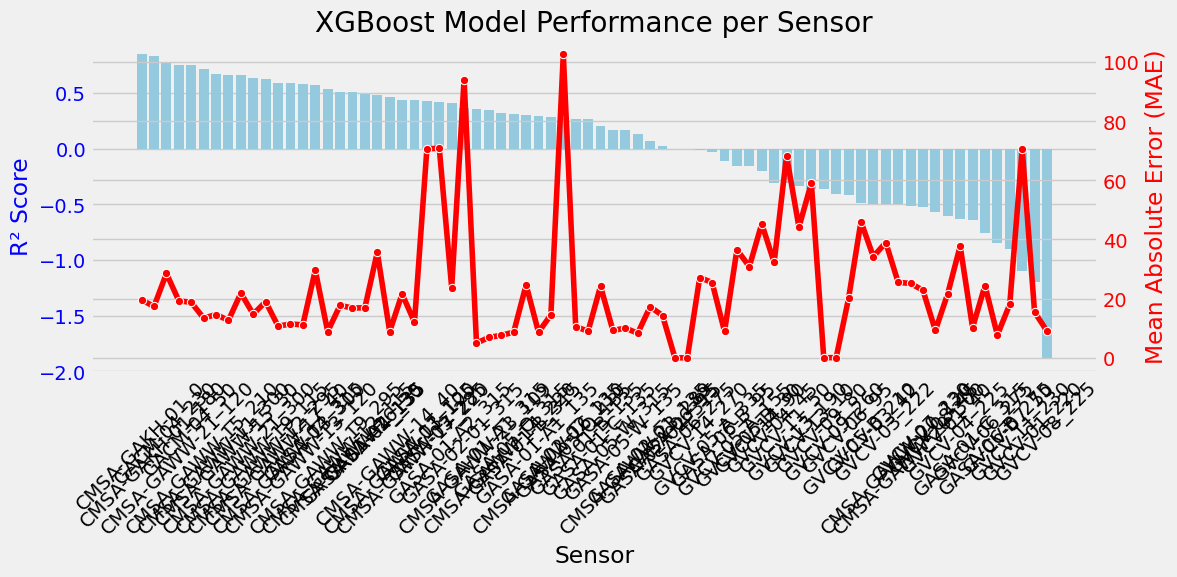

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Collect results into a DataFrame
results_df = pd.DataFrame({
    'Sensor': sensor_cols,
    'MAE': mae_per_sensor,
    'R2': r2_per_sensor
}).sort_values('R2', ascending=False)

# Print a summary table
print("\n📈 Model Performance Summary:")
print(results_df.round(3))

# Plot MAE and R2 for each sensor
fig, ax1 = plt.subplots(figsize=(12, 6))

# Left y-axis: R2 scores
sns.barplot(x='Sensor', y='R2', data=results_df, color='skyblue', ax=ax1)
ax1.set_ylabel('R² Score', color='blue')
ax1.set_xlabel('Sensor')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='x', rotation=45)

# Right y-axis: MAE values
ax2 = ax1.twinx()
sns.lineplot(x='Sensor', y='MAE', data=results_df, color='red', marker='o', ax=ax2)
ax2.set_ylabel('Mean Absolute Error (MAE)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('XGBoost Model Performance per Sensor')
plt.tight_layout()
plt.show()


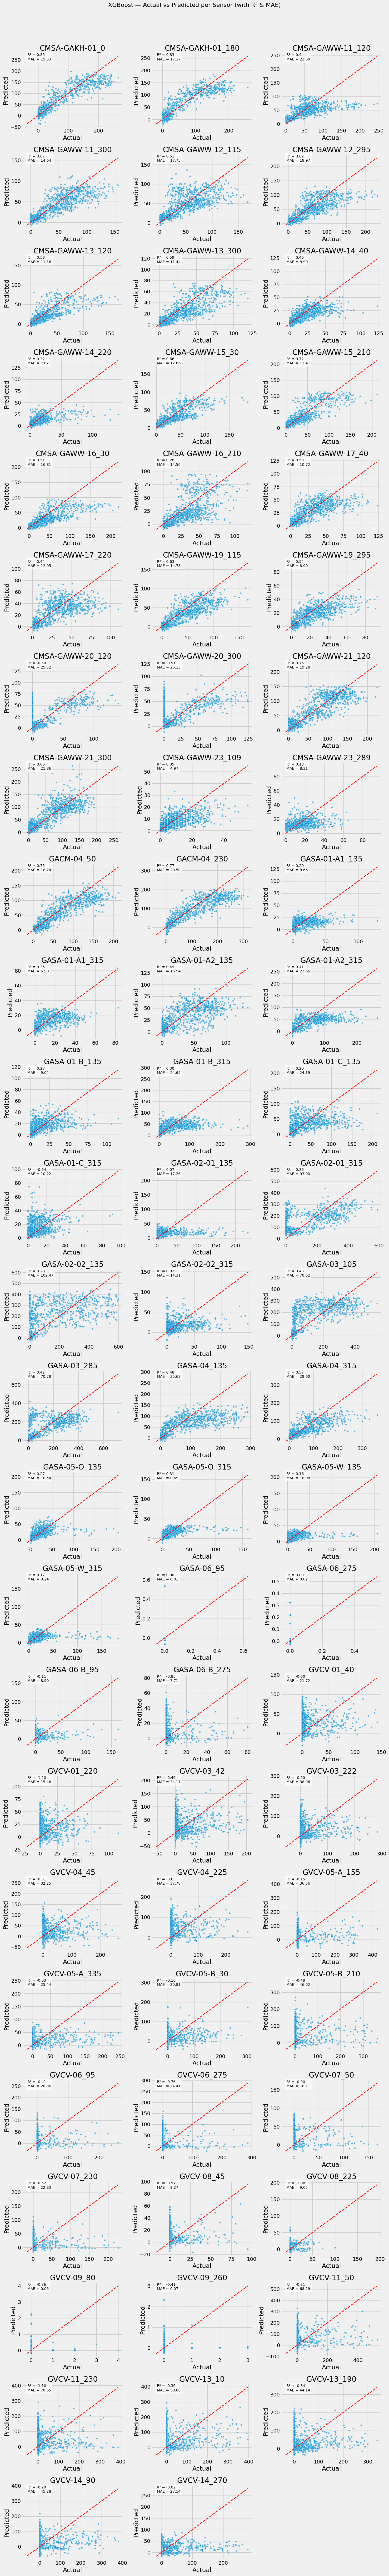

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

n_sensors = len(sensor_cols)
n_cols = 3
n_rows = int(np.ceil(n_sensors / n_cols))

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

X_test = merged_df_test[feature_cols]
X_test_scaled = scaler.transform(X_test)

for i, sensor in enumerate(sensor_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    
    y_test = merged_df.loc[X_test.index, sensor]

    model = models[sensor]
    y_pred = model.predict(X_test_scaled)

    # Scatter plot
    sns.scatterplot(x=y_test, y=y_pred, s=20, alpha=0.6)
    
    # 1:1 reference line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    
    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Annotate
    plt.text(
        0.05, 0.90,
        f"R² = {r2:.2f}\nMAE = {mae:.2f}",
        transform=plt.gca().transAxes,
        fontsize=10,
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
    )
    
    plt.title(sensor)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")

plt.suptitle("XGBoost — Actual vs Predicted per Sensor (with R² & MAE)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


/var/folders/r7/j4cx6h396gqdzk5s_4h9vf180000gn/T/ipykernel_70194/1534252077.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/r7/j4cx6h396gqdzk5s_4h9vf180000gn/T/ipykernel_70194/1534252077.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/r7/j4cx6h396gqdzk5s_4h9vf180000gn/T/ipykernel_70194/1534252077.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/r7/j4cx6h396gqdzk5s_4h9vf180000gn/T/ipykernel_70194/1534252077.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated a

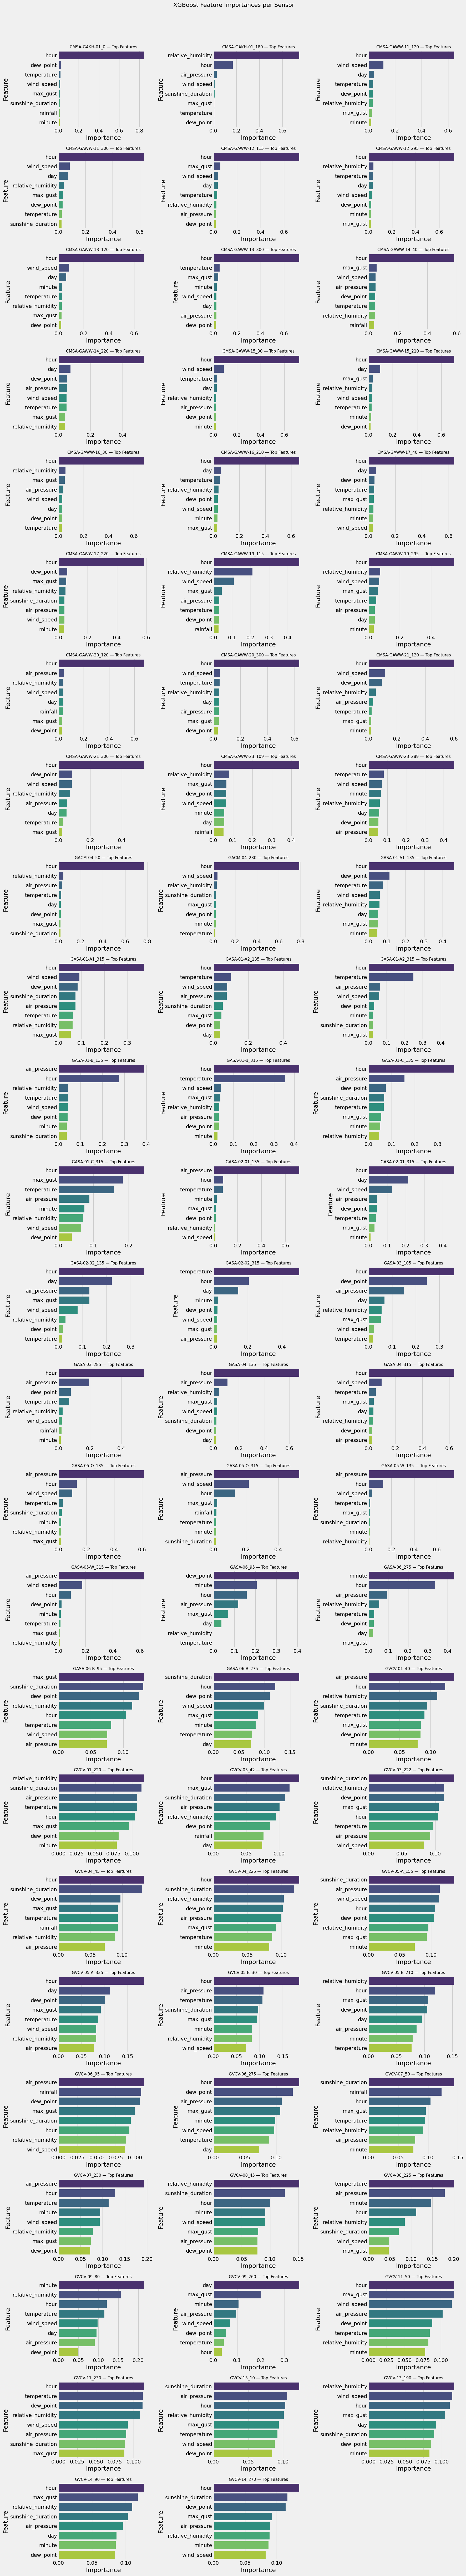

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

# Create subplots
n_sensors = len(sensor_cols)
n_cols = 3
n_rows = int(np.ceil(n_sensors / n_cols))

plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, sensor in enumerate(sensor_cols):
    plt.subplot(n_rows, n_cols, i + 1)
    
    model = models[sensor]
    importances = model.feature_importances_
    importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances,
    }).sort_values('Importance', ascending=False)
    
    sns.barplot(
        data=importance_df.head(8),  # top 8 features
        x='Importance', y='Feature', palette='viridis'
    )
    
    plt.title(f"{sensor} — Top Features", fontsize=11)
    plt.xlabel("Importance")
    plt.ylabel("Feature")

plt.suptitle("XGBoost Feature Importances per Sensor", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()
